# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Calculating the mean and standard deviation for normalization
# (https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/12)
import os 
cur_dir = os.getcwd()

traindata_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root=cur_dir, train=True, download=True, transform=traindata_transform)
print(train_dataset.train_data.shape)
print(train_dataset.train_data.mean(axis=(0,1,2)))
print(train_dataset.train_data.std(axis=(0,1,2)))

#print(train_dataset[0])

Files already downloaded and verified
(50000, 32, 32, 3)
[ 125.30691805  122.95039414  113.86538318]
[ 62.99321928  62.08870764  66.70489964]


In [3]:
# Adding the cuda agnostic
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transforms 
traindata_transform = transforms.Compose([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.49139968, 0.48215841, 0.44653091],
                                                               [0.24703223, 0.24348513, 0.26158784])
                                        ])

testdata_transform = transforms.Compose([transforms.ToTensor(), 
                                         transforms.Normalize([0.49139968, 0.48215841, 0.44653091],
                                                              [0.24703223, 0.24348513, 0.26158784]),
                                        ])

# Create training set and define training dataloader
train_dataset = torchvision.datasets.CIFAR10(cur_dir, train=True, transform=traindata_transform, download=True)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
test_dataset = torchvision.datasets.CIFAR10(cur_dir, train=False, transform=testdata_transform, download=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

The tensor has the shape of torch.Size([64, 3, 32, 32])


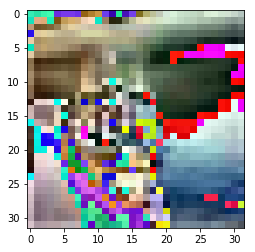

In [5]:
# Explore data
#show5(testloader)
img, lbl = next(iter(testloader))
transform = transforms.ToPILImage()
plt.imshow(transform(img[0]))

print(f"The tensor has the shape of {next(iter(trainloader))[0].shape}")

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
n_input = next(iter(trainloader))[0].shape[2] ** 2
n_hidden1 = 512
n_hidden2 = 256
n_hidden3 = 128
n_output = 10

# flatten inside sequential https://stackoverflow.com/questions/53953460/how-to-flatten-input-in-nn-sequential-in-pytorch
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
       
        # the convolutional + pooling layer is adapted from the LeNet algorithm
        # https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=20, kernel_size=(5,5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5,5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            Flatten(),
            nn.Linear(1800, n_hidden1),
            nn.ReLU(),
            nn.Linear(n_hidden1, n_hidden2),
            nn.ReLU(),
            nn.Linear(n_hidden2, n_hidden3),
            nn.ReLU(),
            nn.Linear(n_hidden3, n_output),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        out = self.main(x)
        
        return out

model = Classifier()

model.to(device)

Classifier(
  (main): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten()
    (7): Linear(in_features=1800, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=256, bias=True)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=128, bias=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=10, bias=True)
    (14): LogSoftmax()
  )
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
criterion = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9) # to avoid the local minima problem

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
num_epoch = 10
print_on_batch = 250
running_loss = 0
steps = 0

train_loss = 0
train_loss_records = []
validation_loss_records = []
accuracy_records = []

for epoch in range(num_epoch):
    for images, labels in trainloader:
        steps += 1
            
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_loss += loss.item()
        
        if steps % print_on_batch == 0:
            test_loss = 0
            accuracy = 0
            
            model.eval()
            with torch.no_grad():
                for images, labels in testloader:
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    output = model(images)
                    loss = criterion(output, labels)
                    test_loss += loss.item()
                    
                    prob = torch.exp(output)
                    
                    top_prob, top_class = prob.topk(1, dim=1)
                    equals = top_class == labels.view(top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{num_epoch}.. "
                  f"Train loss: {running_loss/print_on_batch:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
    # to record losses after each epoch
    train_loss_records.append(train_loss/len(trainloader))
    train_loss = 0

    test_loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()

            prob = torch.exp(output)

            top_prob, top_class = prob.topk(1, dim=1)
            equals = top_class == labels.view(top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        accuracy = accuracy/len(testloader)
        test_loss = test_loss/len(testloader)
    model.train()

    validation_loss_records.append(test_loss)
    accuracy_records.append(accuracy)


Epoch 1/10.. Train loss: 2.270.. Test loss: 2.091.. Test accuracy: 0.247
Epoch 1/10.. Train loss: 1.938.. Test loss: 1.747.. Test accuracy: 0.368
Epoch 1/10.. Train loss: 1.705.. Test loss: 1.542.. Test accuracy: 0.434
Epoch 2/10.. Train loss: 1.550.. Test loss: 1.505.. Test accuracy: 0.449
Epoch 2/10.. Train loss: 1.470.. Test loss: 1.360.. Test accuracy: 0.507
Epoch 2/10.. Train loss: 1.373.. Test loss: 1.252.. Test accuracy: 0.550
Epoch 3/10.. Train loss: 1.281.. Test loss: 1.189.. Test accuracy: 0.575
Epoch 3/10.. Train loss: 1.211.. Test loss: 1.116.. Test accuracy: 0.608
Epoch 3/10.. Train loss: 1.154.. Test loss: 1.060.. Test accuracy: 0.632
Epoch 4/10.. Train loss: 1.058.. Test loss: 1.015.. Test accuracy: 0.648
Epoch 4/10.. Train loss: 1.024.. Test loss: 1.007.. Test accuracy: 0.649
Epoch 4/10.. Train loss: 0.989.. Test loss: 0.977.. Test accuracy: 0.653
Epoch 5/10.. Train loss: 0.919.. Test loss: 0.947.. Test accuracy: 0.676
Epoch 5/10.. Train loss: 0.861.. Test loss: 0.903..

Plot the training loss (and validation loss/accuracy, if recorded).

[1.9543583794018191, 1.4505640102926727, 1.190584901120047, 1.0057013590469994, 0.8545663364403083, 0.738303854070661, 0.625571946391974, 0.5250140828702151, 0.4299480983668276, 0.3474542925710721]
[1.5540546725510032, 1.2815952847717673, 1.112955020871132, 0.9694084490940069, 0.9137888353341704, 0.9617720965746861, 0.8455992728281932, 0.916528706717643, 0.9644948469985063, 1.0364687382035953]


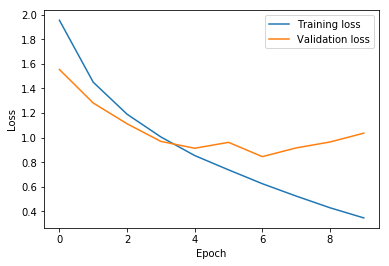

In [9]:
plt.plot(train_loss_records, label='Training loss')
plt.plot(validation_loss_records, label='Validation loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show

print(train_loss_records)
print(validation_loss_records)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
test_loss = 0
accuracy = 0

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)
        test_loss += loss.item()

        prob = torch.exp(output)

        top_prob, top_class = prob.topk(1, dim=1)
        equals = top_class == labels.view(top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print("Test results --  "
      f"Test loss: {test_loss/len(testloader):.3f}.. "
      f"Test accuracy: {accuracy/len(testloader):.3f}")
running_loss = 0
model.train();

Test results --  Test loss: 1.035.. Test accuracy: 0.716


## Saving your model
Using `torch.save`, save your model for future loading.

In [11]:
# It is assumed that the network's architecture will use the same one here, so we only save the weights
torch.save(model.state_dict(), 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

Based on the development so far, I believe that the better option is to develop the solution in-house. The model trained here is based on [LeNet algorithm](https://en.wikipedia.org/wiki/LeNet), which is considered quite shallow compared to modern and more advanced solutions developed inrecent years. Despite that, the accuracy is comparable to the Detectocorp's model, which is about 70% for CIFAR-10. It is expected that upon application of transfer learning on the more advanced models, with fine tuning done on our specific problem (the fully connected layer), higher and better accuracy could be achieved.

To achieve the 71% accuracy, the learning rate was reduced, as well as adding the depth of the fully connected layer (it was previously around 68%). It is also possible that with image augmentation to produce more inputs, this accuracy could be improved as well. Thus, the more cost-effective solution is to continue the development in-house.


## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).